<a href="https://colab.research.google.com/github/EliaTorre/NLP/blob/main/Neural_Machine_Translation_by_Jointly_Learning_to_Align_and_Translate_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation by Jointly Learning to Align and Translate

In [ ]:
import random
import math
import time

import spacy
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

from torchtext.data.metrics import bleu_score

Downloading Spacy packages

In [ ]:
#!python -m spacy download en
#!python -m spacy download de

Initializing the seed to enforce reproducibility of results

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Loading the spacy modules for German and English

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

Defining the tokenizer functions

In [ ]:
def deutsch_tokenizer(text):
    return [token.text for token in spacy_de.tokenizer(text)]

def english_tokenizer(text):
    return [token.text for token in spacy_en.tokenizer(text)]

Through pytorch's Field function I appended "sos" and "eos" tokens at the beginning and end of the sentences and transformed all of the sentences' words to lowercase

In [ ]:
DE = Field(tokenize = deutsch_tokenizer, init_token = '<sos>', eos_token = '<eos>', lower = True)
EN = Field(tokenize = english_tokenizer, init_token = '<sos>', eos_token = '<eos>', lower = True)

I downloaded the Multi30K dataset which contains the parallel german-english-french tranlsation of approx. 30k sentences with approx. 12 words per sentence each. I used torchtext.datasets split attribute to divide the dataset in train/validation/test, where "exts" attribute specifies which language to use as source and which to use as target

In [ ]:
train_data, validation_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (DE, EN))

downloading training.tar.gz


100%|██████████| 1.21M/1.21M [00:04<00:00, 302kB/s]


downloading validation.tar.gz


100%|██████████| 46.3k/46.3k [00:00<00:00, 92.4kB/s]


downloading mmt_task1_test2016.tar.gz


100%|██████████| 66.2k/66.2k [00:00<00:00, 88.1kB/s]


I proceed in building the german (DE) and english (EN) vocabularies from the training data enforcing that only words which appear at least twice are included, otherwise an "UNK" token is put in their place

In [ ]:
DE.build_vocab(train_data, min_freq = 2)
EN.build_vocab(train_data, min_freq = 2)

I defined the device such that GPU can be exploited to speed up the training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

I define the iterators with a batch of 128, such that the data is transformed to an iterable object with a source and target attribute that maps tokenized words to their index in the vocabulary.
I used "BucketIterator" instead of the standard "Iterator" because it creates batches that minimize the padding within sentences, such that it speeds up computation

In [ ]:
batch = 128
train_iterator, validation_iterator, test_iterator = BucketIterator.splits((train_data, validation_data, test_data), batch_size = batch, device = device)

Following the https://arxiv.org/abs/1409.0473 paper, I implemented an architecture that exploits "attention" to avoid the compression of the source sentence in the context vector performed in the previous model. Here, the decoder is able of looking at the whole source sentence through the hidden states at every decoding step. 

The implementation of the Encoder relies on a bidirectional single layer GRU, which is capable of performing the computation of the "forward RNN" (sentence from left to right) and "backward RNN" (sentence from right to left). 

In particular, as seen in the previous model, the encoder receives the "embdedded" sentence, it performs the computation of the "outputs", i.e., hidden states at each time step of both forward and backward RNN, and "hidden", i.e., the final hidden states of both forward and backward RNN. 

The shape of "outputs" can be though as a list of the hidden states, where each element is a tuple of both the forward and backward hidden state. H = [h_1, h_2, ..., h_t] where h_1 = [h_1(forward), h_1(backward)].

On the other side, the final hidden states contained in "hidden" represent the top layer of the forward RNN hidden state after the final time-step, i.e., after it has seen the last word in the sentence, and the top layer of the backward RNN hidden state after the final time-step, i.e., after it has seen the first word in the sentence. 

Finally, since the decoder layer is not bidirectional, following several implementations that can be found online, I decided to apply a little deviation to approach stated in the paper. Indeed, while the paper feeds only the first backward RNN hidden state transformed through a linear layer. I concatenated the two final hidden layers, applied a linear layer and a tanh activation to obtain the final context vector to be fed to the decoder. 


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hiddden_dim, decoder_hidden_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hiddden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hiddden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, de):
        embedded = self.dropout(self.embedding(de))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden

The novelty of this architecture is in the "Attention" class, indeed it allows us to determine which words in the source sentence should be paid more attention to predict the next word to decode. 

This layer calculates an attention vector based on the previous hidden state of the decoder and all of the forward and backward hidden states contained derived from the encoder.  

Following the paper, we firstly calculate the energy by passing the "encoder outputs" and the "(repeated) decoder hidden state" through the attention layer and a tanh activation. Then, the attention is obtained by multiplying the energy vector by a tensor v, i.e., a vector that represents the weights of a weighted sum (it is randomly initialized and learned through backpropagation).

Finally the attention over the source sentence is obtained by applying Softmax to the previously evaluated attention. 

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn = nn.Linear((encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim)
        self.v = nn.Linear(encoder_hidden_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        batch = encoder_outputs.shape[1]
        de_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, de_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = self.v(energy).squeeze(2)

        return F.softmax(attention, dim=1)

As previously mentioned, the Decoder is a one direction GRU Recurrent Neural Network which features an additional attention layer compared to the previous architecture. It evaluates "attention" of the "embedded source sequence", computes the "weighted" vector as a weighted sum of the attention vector and the list of hidden states derived from the encoder. It then concatenates the "embedded" and "weighted" vectors and feeds them, together with the previous decoder hidden state, to the RNN to evaluate the current decoder hidden state. 

Finally, the current "hidden" state, the "weighted" vector and "embedded" source sequence are concatenated and passed through a linear layer to obtain the prediction.  

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dimension, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear((encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))

        return prediction, hidden.squeeze(0), a.squeeze(1)

The Seq2Seq class aims at combining encoder and decoder. It receives the source sequence, feeds it to the encoder which will return "encoder_outputs" and "hidden". Then it performs a loop for (en_len) times where the decoder receives the "input" token, previous decoder "hidden" state and all of the "encoder_outputs". It then collects the prediction and continues the iteration.  

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, de, en, ratio = 0.5):
        batch = de.shape[1]
        en_len = en.shape[0]
        en_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(en_len, batch, en_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(de)
        input = en[0,:]

        for t in range(1, en_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            force = random.random() < ratio
            best = output.argmax(1) 
            input = en[t] if force else best

        return outputs

Here I initialize the parameters of the model

In [ ]:
input_dim, output_dim = len(DE.vocab), len(EN.vocab)
encoder_embedding_dim, decoder_embedding_dim = 256, 256
encoder_hidden_dim, decoder_hidden_dim = 512, 512
encoder_dropout, decoder_dropout = 0.5, 0.5

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)
encoder = Encoder(input_dim, encoder_embedding_dim, encoder_hidden_dim, decoder_hidden_dim, encoder_dropout)
decoder = Decoder(output_dim, decoder_embedding_dim, encoder_hidden_dim, decoder_hidden_dim, decoder_dropout, attention)

model = Seq2Seq(encoder, decoder, device).to(device)

Here I simplified a bit the initialization of the weights in the model as compared to the weight initialization followed in the paper. In particular, I am initializing all of the biases to zero and all of the weights according to a normal distribution centered around 0 with standard deviation of 0.01. 

Instead, the paper uses the following weight initialization scheme: 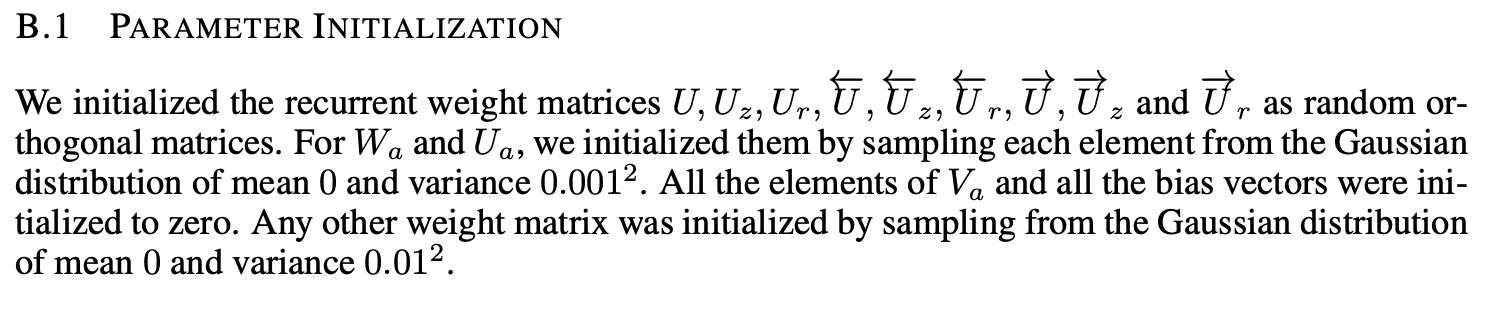

In [ ]:
def weights(model):
    for n, p in model.named_parameters():
        if 'weight' in n:
            nn.init.normal_(p.data, mean=0, std=0.01)
        else:
            nn.init.constant_(p.data, 0)
model.apply(weights);

In [ ]:
def parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {parameters(model):,} trainable parameters')

The model has 20,518,917 trainable parameters


Here I defined the optimizer, i.e., "ADAM", and the loss function, i.e., "CrossEntropyLoss". In particular, by setting the "ignore_index" parameter to "en_pad_idx", it calculates the avg. loss per token ignoring the loss on "pad" tokens

In [ ]:
optimizer = optim.Adam(model.parameters())
en_pad_idx = EN.vocab.stoi[EN.pad_token]
loss_function = nn.CrossEntropyLoss(ignore_index = en_pad_idx)

Next, I define the functions "train" and "test". 

In the first one, I am setting "model.train()" such that dropout layer is considered when running the model. It iterates over the data iterator to update the parameters of the model: 
- Gets the german and english sentences.
- Set to zero the gradients calculated previously.
- Runs the model to obtain the predictions. 
- It reshapes input and output through .view() to fit the loss function. 
- Performs backpropagation and clips the gradient to avoind exploding gradients problems.
- Updates the parameters through optimizer.step() 
- Updates epoch_loss

Then it returns the epoch_loss averaged over all batches. 

In [ ]:
def train(model, iterator, optimizer, loss_function, clip):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):    
        de = batch.src
        en = batch.trg
        optimizer.zero_grad()
        output = model(de, en)        
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        en = en[1:].view(-1)
        loss = loss_function(output, en)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The "test" function works similarly to the "train" function, however in this case, I set model.eval() such that no parameter optimization and dropout is performed.
Furthermore, torch.no_grad() is introduced to avoid the computational cost of performing the gradients calculation.

In [ ]:
def test(model, iterator, loss_function):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            de = batch.src
            en = batch.trg
            output = model(de, en, 0) 
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            en = en[1:].view(-1)
            loss = loss_function(output, en)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The following "translate" function has the purpose of generating a translation of the german text and it is needed to evaluate the model according to the BLEU score

In [ ]:
def translate(sentence, de_field, en_field, model, device, max = 50):
    model.eval()
    tokens = [token.lower() for token in sentence]
    tokens = [de_field.init_token] + tokens + [de_field.eos_token]
    de_idx = [de_field.vocab.stoi[token] for token in tokens]
    de_tensor = torch.LongTensor(de_idx).unsqueeze(1).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(de_tensor)
      
    en_idx = [en_field.vocab.stoi[en_field.init_token]]
    attentions = torch.zeros(max, 1, len(de_idx)).to(device)
    
    for i in range(max):
        en_tensor = torch.LongTensor([en_idx[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(en_tensor, hidden, encoder_outputs)

        attentions[i] = attention
        pred_token = output.argmax(1).item()
        en_idx.append(pred_token)

        if pred_token == en_field.vocab.stoi[en_field.eos_token]:
            break
    
    en_tokens = [en_field.vocab.itos[i] for i in en_idx]
    
    return en_tokens[1:], attentions[:len(en_tokens)-1]

The "bleu" function allows the computation of the BLEU score, which is a a metric specifically designed to assess the quality of a translation. It checks the overlapping between the actual and predicted english sequences in terms of their n-grams and outputs a score between 0 and a 100 (with a 100 being a perfect translation)

In [ ]:
def bleu(data, de_field, en_field, model, device, max = 50):
    ens = []
    pred_ens = []

    for x in data:
        de = vars(x)['src']
        en = vars(x)['trg']
        pred_en, _ = translate(de, de_field, en_field, model, device, max)
        pred_en = pred_en[:-1]
        pred_ens.append(pred_en)
        ens.append([en])

    return bleu_score(pred_ens, ens)

Here I defined a function to measure the time elapsed between each epoch of the training process

In [ ]:
def count_time(start, end):
    elapsed = end - start
    mins = int(elapsed / 60)
    secs = int(elapsed - (mins * 60))
    return mins, secs

Finally, I defined the training iteration process of the architecture which evaluates the "train_loss" and "validation_loss" of each epoch and keeps track of the best parameters configuration according to the validation_loss. 

It then prints a summary of train/validation loss of each epoch and the correspondent perplexity metric

In [ ]:
epochs , clip, best = 10, 1, float('inf')

for epoch in range(epochs):
    start = time.time()
    train_loss = train(model, train_iterator, optimizer, loss_function, clip)
    validation_loss = test(model, validation_iterator, loss_function)
    end = time.time()
    mins, secs = count_time(start, end)
    
    if validation_loss < best:
        best = validation_loss
        torch.save(model.state_dict(), 'GRU(Attention)-model.pt')
    
    print(f'Epoch: {epoch + 1}, Time: {mins}m {secs}s')
    print(f'Train Loss: {train_loss:.3f}, Validation Loss: {validation_loss:.3f} ')
    print(f'Train PPL: {math.exp(train_loss):7.3f}, Validation PPL: {math.exp(validation_loss):7.3f}\n')

Epoch: 1, Time: 0m 58s
Train Loss: 5.017, Validation Loss: 4.791 
Train PPL: 150.918, Validation PPL: 120.401

Epoch: 2, Time: 0m 57s
Train Loss: 4.099, Validation Loss: 4.272 
Train PPL:  60.306, Validation PPL:  71.636

Epoch: 3, Time: 0m 57s
Train Loss: 3.390, Validation Loss: 3.717 
Train PPL:  29.680, Validation PPL:  41.132

Epoch: 4, Time: 0m 58s
Train Loss: 2.856, Validation Loss: 3.351 
Train PPL:  17.386, Validation PPL:  28.537

Epoch: 5, Time: 0m 57s
Train Loss: 2.497, Validation Loss: 3.227 
Train PPL:  12.140, Validation PPL:  25.202

Epoch: 6, Time: 0m 58s
Train Loss: 2.180, Validation Loss: 3.249 
Train PPL:   8.848, Validation PPL:  25.760

Epoch: 7, Time: 0m 57s
Train Loss: 1.940, Validation Loss: 3.209 
Train PPL:   6.962, Validation PPL:  24.747

Epoch: 8, Time: 0m 57s
Train Loss: 1.740, Validation Loss: 3.223 
Train PPL:   5.695, Validation PPL:  25.113

Epoch: 9, Time: 0m 57s
Train Loss: 1.598, Validation Loss: 3.330 
Train PPL:   4.943, Validation PPL:  27.946

E

In the following cells, I evaluate the performance of the trained architecture on an unseen sample test and compute its BLEU score

In [ ]:
model.load_state_dict(torch.load('GRU(Attention)-model.pt'))
test_loss = test(model, test_iterator, loss_function)
print(f'Test Loss: {test_loss:.3f}, Test PPL: {math.exp(test_loss):7.3f}')

Test Loss: 3.180, Test PPL:  24.037


In [ ]:
bleu_score = bleu(test_data, DE, EN, model, device)
print(f'BLEU score: {bleu_score*100:.2f}')

BLEU score: 30.54
